# CandyCare

__PML WS 2021/22__ <br>
_by Julian Mierisch and Anna Martynova_

### Goals
1. Make Model which predicts which win percentage a given new candy has
2. Predict which combination has highest win propability
3. Cluster data

### Import packages and data

In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from operator import itemgetter
# conda install -c conda-forge kneed

In [2]:
candyDataAll = pd.read_csv('candy-data.csv')
candyDataAll

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,WelchÕs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


## Data exploration 
### Inspect distribution of candy attributes in dataset

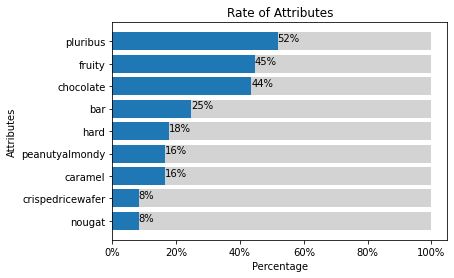

In [3]:
#Show distribution of candy attributes in dataset
candyAttributes = candyDataAll.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
data = {'Attributes': candyAttributes.columns, 'Values': candyAttributes.sum()/len(candyAttributes)}  
candyAttrPercent = pd.DataFrame(data).reset_index().drop(columns=['index']).sort_values(by=['Values'])

fig, ax = plt.subplots()
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1]/2,y_list[i-1], ha="center")
plt.barh(candyAttrPercent['Attributes'], candyAttrPercent['Values'])
for index, value in enumerate(candyAttrPercent['Values']):
    plt.text(value, index, str("{:.0%}".format(value)))
plt.barh(candyAttrPercent['Attributes'], 1-candyAttrPercent['Values'], left=candyAttrPercent['Values'], color="lightgrey")
plt.title('Rate of Attributes')
plt.ylabel('Attributes')
plt.xlabel('Percentage')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.show()

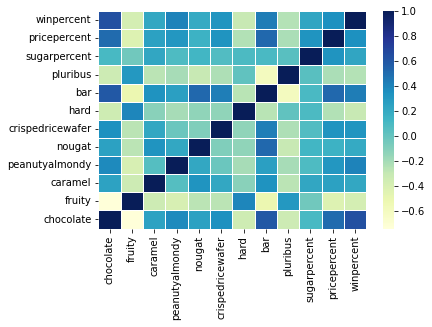

In [4]:
#Attribute correlation analysis
candyData = candyDataAll.drop(columns=['competitorname'])
corr = candyData.corr(method='pearson')
heatmap = sns.heatmap(corr, linewidth=0.5,cmap="YlGnBu").invert_yaxis()

### Inspect feature distribution

In [1]:
# Feature distribution
sugar = candyDataAll['sugarpercent']*100
price = candyDataAll['pricepercent']*100
win = candyDataAll['winpercent']
colors = ['tab:red', 'tab:green', 'tab:blue']
data = [sugar, price, win]
titles = ['Sugar percentage distribution','Price percentage distribution','Win percentage distribution']
labels = ['Sugar percentage','Price percentage','Win percentage']

fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)

for i in range(3):
    ax[i].hist(data[i], bins=10, color=colors[i], alpha = 0.5)
    ax[i].title.set_text(titles[i])
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel('Amount')

NameError: name 'candyDataAll' is not defined

## Cluster Analysis
To analyze which features are most beneficial for high win percentage, we have to cluster the datapoints and analyze the features, that influence the average win percentage (further: awp) of each cluster

### Detect suitable cluster amount

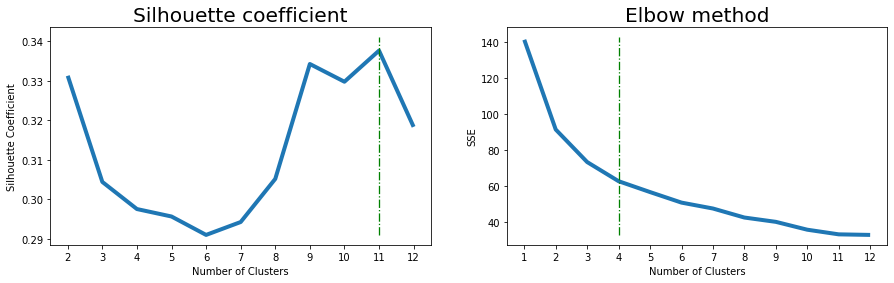

The optimal cluster amount based on silhouette coefficient method is  11
The optimal cluster amount based on elbow method is  4

Following, we will analyze both KMeans with  4  and with  11  clusters to decide which cluster has highes average winpercent with acceptable cluster size (ca. >10)


In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
# conda install -c conda-forge kneed

kmeans = KMeans(n_clusters = 2)
candyData = candyDataAll.drop(columns=['winpercent','competitorname'])

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

# https://realpython.com/k-means-clustering-python/#:~:text=The%20k%2Dmeans%20clustering%20method,data%20objects%20in%20a%20dataset.&text=These%20traits%20make%20implementing%20k,novice%20programmers%20and%20data%20scientists.
# to choose the appropriate number of clusters:
# silhouette coefficient = measure of cluster cohesion and separation
# values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters

silhouette_coefficients = []
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(candyData)
    score = silhouette_score(candyData, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
ax[0].set_title("Silhouette coefficient")
ax[0].plot(range(2, 13), silhouette_coefficients)
ax[0].set_xticks(range(2, 13))
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("Silhouette Coefficient")
ax[0].vlines(silhouette_coefficients.index(max(silhouette_coefficients))+2, ymin=min(silhouette_coefficients), ymax=1.01*max(silhouette_coefficients), colors='green', linestyles='dashdot', linewidth=1.3)


# to choose the appropriate number of clusters:
# elbow = measure of cluster cohesion and separation

sse = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(candyData)
    sse.append(kmeans.inertia_)
ax[1].set_title("Elbow method")
ax[1].plot(range(1, 13), sse)
ax[1].set_xticks(range(1, 13))
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("SSE")
kl = KneeLocator(
    range(1, 13), sse, curve="convex", direction="decreasing")
ax[1].vlines(kl.elbow, ymin=min(sse), ymax=max(sse)*1.01, colors='green', linestyles='dashdot', linewidth=1.3)

plt.show()
print("The optimal cluster amount based on silhouette coefficient method is ", silhouette_coefficients.index(max(silhouette_coefficients))+2)
print("The optimal cluster amount based on elbow method is ", kl.elbow)
print()
print("Following, we will analyze both KMeans with ", kl.elbow, " and with ", silhouette_coefficients.index(max(silhouette_coefficients))+2, 
     " clusters to decide which cluster has highes average winpercent with acceptable cluster size (ca. >10)")



### Analyze clusters with KMeans

Since winpercentage is our target data, we exclude it from data which we cluster. Afterwards, we map the average winpercentage on resulted cluster and select the cluster with highest average winpercentage for further analysis of its features

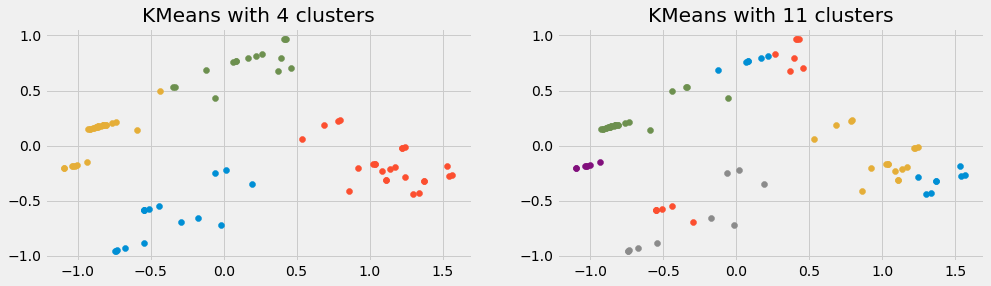

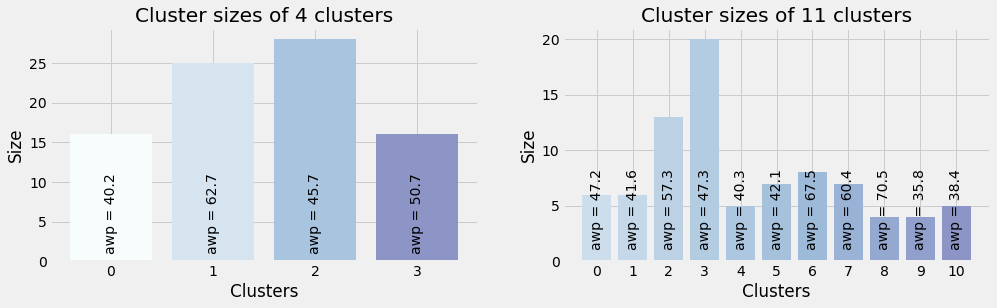

The largest of  4  clusters is: Cluster  2
The largest of  11  clusters is: Cluster  3


In [7]:
def autolabel(rects,axes, bar_plot):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        axes.text(rect.get_x() + rect.get_width()/2., 1,
                "awp = "+ str(winRates[idx]),
                ha='center', va='bottom', rotation=90)

pca = PCA(2)
cD = pca.fit_transform(candyData)

fig, ax = plt.subplots(1,2)
fig2,ax2 = plt.subplots(1,2)
fig.set_figwidth(15)
fig2.set_figwidth(15)


kmeansS = KMeans(n_clusters=silhouette_coefficients.index(max(silhouette_coefficients))+2)
label = kmeansS.fit_predict(cD)
u_labels = np.unique(label)
clusterSizes = []
winRates = []

# plot scatters for 11 clusters
for i in u_labels:
    ax[1].scatter(cD[label == i, 0], cD[label == i, 1], label = i)
    clusterSizes.append(cD[label == i,0].size)
    winPercentages = []
    for k in cD[label==i]:
        winPercentages.append(candyDataAll['winpercent'][np.where(cD==k)[0][0]])
    winRates.append(round(sum(winPercentages)/len(winPercentages),1))
ax[1].set_title("KMeans with " + str(silhouette_coefficients.index(max(silhouette_coefficients))+2) + " clusters"),

# plot barchart
colors = plt.cm.BuPu(np.linspace(0.2, 0.5, len(clusterSizes)))
#plt.set_facecolor('white')
bar_plt2 = ax2[1].bar(range(0,len(clusterSizes)),clusterSizes, color=colors, tick_label=range(0,len(clusterSizes)))
ax2[1].set_xlabel('Clusters')
ax2[1].set_ylabel('Size')
ax2[1].set_title('Cluster sizes of ' + str(len(clusterSizes)) + ' clusters')
maxClusterSIL = clusterSizes.index(max(clusterSizes))
autolabel(bar_plt2,ax2[1],bar_plt2)



kmeansE = KMeans(n_clusters=kl.elbow)
label = kmeansE.fit_predict(cD)
u_labels = np.unique(label)
clusterSizes = []
winRates = []

# plot scatters for 4 clusters
for i in u_labels:
    ax[0].scatter(cD[label == i, 0], cD[label == i, 1], label = i)
    clusterSizes.append(cD[label == i,0].size)
    winPercentages = []
    for k in cD[label==i]:
        winPercentages.append(candyDataAll['winpercent'][np.where(cD==k)[0][0]])
    winRates.append(round(sum(winPercentages)/len(winPercentages),1))
ax[0].set_title("KMeans with " + str(kl.elbow) + " clusters")

# plot barchart
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(clusterSizes)))
bar_plt = ax2[0].bar(range(0,len(clusterSizes)),clusterSizes, color=colors, tick_label=range(0,len(clusterSizes)))
ax2[0].set_xlabel('Clusters')
ax2[0].set_ylabel('Size')
ax2[0].set_title('Cluster sizes of ' + str(len(clusterSizes)) + ' clusters')
maxClusterEL = clusterSizes.index(max(clusterSizes))
autolabel(bar_plt,ax2[0],bar_plt)

plt.show()

print('The largest of ', kl.elbow, ' clusters is: Cluster ', maxClusterEL)
print('The largest of ', silhouette_coefficients.index(max(silhouette_coefficients))+2, ' clusters is: Cluster ', maxClusterSIL)


As we can see, the highest awp of 4 clusters is 63.8 with 25 datapoints; the highest awp of 11 clusters is 70.5 with 4 datapoints. Though the cluster with awp of 70.5 seems to be more beneficial, due to it containing only 4 datapoints, which is to little for a substantial analysis, we choose to analyze the features of the cluster wit awp=63.8 and 25 datapoints.

In [8]:
awpIdx = winRates.index(max(winRates))
clusterCandies = pd.DataFrame(columns=candyDataAll.columns)

for k in cD[label==awpIdx]:
    clusterCandies = clusterCandies.append(candyDataAll.loc[np.where(cD==k)[0][0]])

clusterCandies = clusterCandies.drop(columns=['winpercent','competitorname'])
vals = []
for factor in clusterCandies.columns:
    vals.append(sum(clusterCandies[factor])/len(clusterCandies))

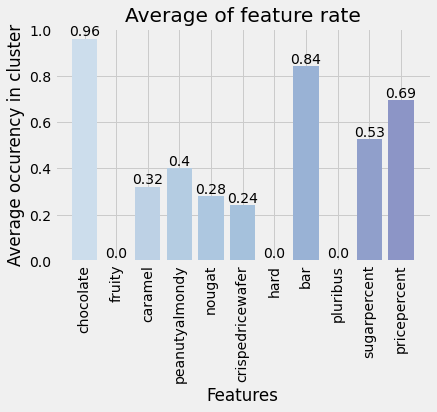

In [9]:
colors = plt.cm.BuPu(np.linspace(0.2, 0.5, len(vals)))
bar_plt = plt.bar(range(0,len(vals)), vals, color=colors, tick_label=clusterCandies.columns)
plt.xticks(rotation = 'vertical')
plt.xlabel('Features')
plt.ylabel('Average occurency in cluster')
plt.title('Average of feature rate')

for idx,bar_plt in enumerate(bar_plt):
        height = bar_plt.get_height()
        plt.text(bar_plt.get_x() + bar_plt.get_width()/2., height,
                round(vals[idx],2),
                ha='center', va='bottom', rotation=0)

# Non-linear-regression
## Dataset preparation

In [10]:
candyDataProcessed = candyDataAll
candyDataProcessed['winpercent'] = candyDataProcessed['winpercent']/100
training_set, test_set = train_test_split(candyDataProcessed, test_size=0.2, random_state = 100)

#sugar
X_train_s = training_set.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
y_train_s = training_set['sugarpercent']

X_test_s = test_set.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
y_test_s = test_set['sugarpercent']

#price
X_train_p = training_set.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
y_train_p = training_set['pricepercent']

X_test_p = test_set.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
y_test_p = test_set['pricepercent']

#win
X_train_w = training_set.drop(columns = ['competitorname', 'winpercent'])
y_train_w = training_set['winpercent']

X_test_w = test_set.drop(columns = ['competitorname', 'winpercent'])
y_test_w = test_set['winpercent']


## Random forest regressor
### Create sugarpercent-predictor

In [11]:
clf_s=RandomForestRegressor(n_estimators=100)
clf_s.fit(X_train_s, y_train_s)
y_pred_s = clf_s.predict(X_test_s)
print("MAE =", mean_absolute_error(y_test_s,y_pred_s))
print("MSE =", mean_squared_error(y_test_s,y_pred_s))

MAE = 0.21882942913833026
MSE = 0.06873529287587565


### Create pricepercent-predictor

In [12]:
clf_p=RandomForestRegressor(n_estimators=100)
clf_p.fit(X_train_p, y_train_p)
y_pred_p = clf_p.predict(X_test_p)
print("MAE =", mean_absolute_error(y_test_p,y_pred_p))
print("MSE =", mean_squared_error(y_test_p,y_pred_p))

MAE = 0.19310535416801825
MSE = 0.04948307278493425


### Create winpercent-predictor

In [13]:
clf_w=RandomForestRegressor(n_estimators=100)
clf_w.fit(X_train_w, y_train_w)
y_pred_w = clf_w.predict(X_test_w)
print("MAE =", mean_absolute_error(y_test_w,y_pred_w))
print("MSE =", mean_squared_error(y_test_w,y_pred_w))

MAE = 0.09533035462284334
MSE = 0.01539841273695784


## K Neighbors regressor
### Create sugarpercent-predictor

In [71]:
knn_regressor_s = KNeighborsRegressor(n_neighbors = 5, 
                                    p = 2, 
                                    weights = 'uniform')
knn_regressor_s.fit(X_train_s, y_train_s)
y_pred_s_knn = knn_regressor_s.predict(X_test_s)
print("MAE =", mean_absolute_error(y_test_s,y_pred_s_knn))
print("MSE =", mean_squared_error(y_test_s,y_pred_s_knn))

MAE = 0.1805411732
MSE = 0.04525526821221666


### Create pricepercent-predictor

In [72]:
knn_regressor_p = KNeighborsRegressor(n_neighbors = 5, 
                                    p = 2, 
                                    weights = 'uniform')
knn_regressor_p.fit(X_train_p, y_train_p)
y_pred_p_knn = knn_regressor_p.predict(X_test_p)
print("MAE =", mean_absolute_error(y_test_p,y_pred_p_knn))
print("MSE =", mean_squared_error(y_test_p,y_pred_p_knn))

MAE = 0.20861176423529415
MSE = 0.05977085202658836


### Create winpercent-predictor

In [73]:
knn_regressor_w = KNeighborsRegressor(n_neighbors = 5, 
                                    p = 2, 
                                    weights = 'uniform')
knn_regressor_w.fit(X_train_w, y_train_w)
y_pred_w_knn = knn_regressor_w.predict(X_test_w)
print("MAE =", mean_absolute_error(y_test_w,y_pred_w_knn))
print("MSE =", mean_squared_error(y_test_w,y_pred_w_knn))

MAE = 0.09626410952941178
MSE = 0.013005556901130064


### Create Methods

In [74]:
# dataline should have the format of a Dataframe!
def predSugar_RF(dataline):
    return clf_s.predict(dataline)

def predPrice_RF(dataline):
    return clf_p.predict(dataline)

def predWin_RF(dataline):
    return clf_w.predict(dataline)

def predSugar_KNN(dataline):
    return knn_regressor_s.predict(dataline)

def predPrice_KNN(dataline):
    return knn_regressor_p.predict(dataline)

def predWin_KNN(dataline):
    return knn_regressor_w.predict(dataline)

### Feature importance

Text(0.5, 1.0, 'Feature importance')

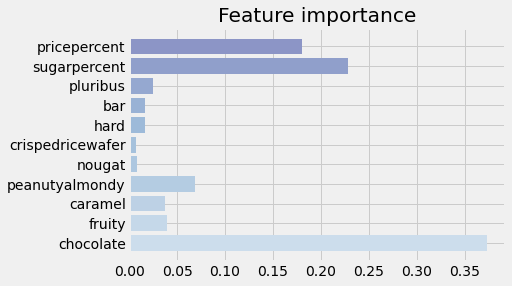

In [15]:
f_imp = []
for i in range(0,len(clf_w.feature_importances_)):
    f_imp.append([X_train_w.columns[i], clf_w.feature_importances_[i]])
f_imp = sorted(f_imp, key=itemgetter(1), reverse=False)
columns = [f_i[0] for f_i in f_imp]
values = [f_i[1] for f_i in f_imp]

colors = plt.cm.BuPu(np.linspace(0.2, 0.5, len(X_train_w.columns)))
plt.barh(columns, values, color=colors)
plt.title("Feature importance")

### Predict New Candy

In [64]:
newCandy = {'competitorname': 'test', 'chocolate':1, 'fruity':0, 'caramel':0, 'peanutyalmondy':1, 'nougat':0, 'crispedricewafer':0, 'hard':0, 'bar':1, 'pluribus':0, 'sugarpercent':0.3, 'pricepercent':0.5, 'winpercent':0.4}
dataline = pd.DataFrame(columns= candyDataAll.columns)
dataline = dataline.append(newCandy, ignore_index=True)
dataline = dataline.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])

pred_sugar = predSugar_RF(dataline)
pred_price = predPrice_RF(dataline)
dataline['sugarpercent'] = pred_sugar[0]
dataline['pricepercent'] = pred_price[0]

pred_win = predWin_RF(dataline)
dataline['winpercent'] = pred_win[0]
dataline

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,1,0,0,1,0,0,0,1,0,0.464404,0.821808,0.654776


In [75]:
newCandy = {'competitorname': 'test', 'chocolate':1, 'fruity':0, 'caramel':0, 'peanutyalmondy':1, 'nougat':0, 'crispedricewafer':0, 'hard':0, 'bar':1, 'pluribus':0, 'sugarpercent':0.3, 'pricepercent':0.5, 'winpercent':0.4}
dataline = pd.DataFrame(columns= candyDataAll.columns)
dataline = dataline.append(newCandy, ignore_index=True)
dataline = dataline.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])

pred_sugar = predSugar_KNN(dataline)
pred_price = predPrice_KNN(dataline)
dataline['sugarpercent'] = pred_sugar[0]
dataline['pricepercent'] = pred_price[0]

pred_win = predWin_KNN(dataline)
dataline['winpercent'] = pred_win[0]
dataline

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,1,0,0,1,0,0,0,1,0,0.3458,0.6298,0.558472
